In [1]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from sklearn.metrics import accuracy_score
from tensorflow import keras
from sklearn import metrics
import tensorflow as tf
import pandas as pd
import numpy as np
import plotting
import hls4ml
import shap
import sys
import os

np.random.seed(77)

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)


def print_dict(d, indent=0):
    align=20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))

In [2]:
options = {
    'v'          : '12',
    'date'       : '2022_10_04',
    'inTagIdent' : '_lTauPtCut18',
    'inTagCalib' : '_lTauPtCut18_uEtacut1.5',
    'caloClNxM'  : '5x9',
    'sparsity'   : 0.25
}

In [3]:
indir = '/data_CMS/cms/motta/Phase2L1T/'+options['date']+'_v'+options['v']
identdir = indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']
calibdir = indir+'/TauCNNCalibrator'+options['caloClNxM']+'Training'+options['inTagCalib']

N = int(options['caloClNxM'].split('x')[0])
M = int(options['caloClNxM'].split('x')[1])

sparsityTag = str(options['sparsity']).split('.')[0]+'p'+str(options['sparsity']).split('.')[1]

In [4]:
X1_id = np.load(identdir+'/X_CNN_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
X2_id = np.load(identdir+'/X_Dense_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
Y_id  = np.load(identdir+'/Y_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']

X1_id = np.float32(X1_id)
X2_id = np.float32(X2_id)
Y_id = np.float32(Y_id)

X1_id_reduced = X1_id[:3000]
X2_id_reduced = X2_id[:3000]
Y_id_reduced = Y_id[:3000]

In [5]:
X1_cal = np.load(calibdir+'/X_CNN_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
X2_cal = np.load(calibdir+'/X_Dense_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
Y_cal  = np.load(calibdir+'/Y_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']

X1_cal = np.float32(X1_cal)
X2_cal = np.float32(X2_cal)
Y_cal = np.float32(Y_cal)

X1_cal_reduced = X1_cal[:3000]
X2_cal_reduced = X2_cal[:3000]
Y_cal_reduced = Y_cal[:3000]

In [6]:
# quantized and pruned models
QCNN = keras.models.load_model(identdir+'/QCNNmodel'+sparsityTag+'Pruned', compile=False)
QDNNident = keras.models.load_model(identdir+'/QDNNmodel'+sparsityTag+'Pruned', compile=False)
QDNNcalib = keras.models.load_model(calibdir+'/TauCNNQCalibrator'+sparsityTag+'Pruned', compile=False)

2022-11-23 12:25:02.699025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /grid_mnt/opt__exp_soft/llr/python/3.9.9/lib/python3.9/site-packages/cv2/../../lib64:/opt/exp_soft/llr/python/3.9.9/lib/vtk:/opt/exp_soft/llr/python/3.9.9/lib:/usr/lib64/classads:/usr/lib64:/usr/lib
2022-11-23 12:25:02.699069: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-23 12:25:02.699549: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) t

In [7]:
# original floating point model without pruning
CNN_FullFloat= keras.models.load_model(identdir+'/CNNmodel', compile=False)
DNNident_FullFloat= keras.models.load_model(identdir+'/DNNmodel', compile=False)
DNNcalib_FullFloat= keras.models.load_model(calibdir+'/TauCNNCalibrator', compile=False)

# QUANTIZED MODELS ONLY

## Create HLS model for the identification CNN and DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: TowerClusterImage, layer type: Input
Layer name: CNNpBNlayer1, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer1
Layer name: RELU_CNNpBNlayer1, layer type: QActivation
  -> Activation (quantized_relu(10,7)), layer name: RELU_CNNpBNlayer1
Layer name: MP_CNNpBNlayer1, layer type: MaxPooling2D
Layer name: CNNpBNlayer2, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer2
Layer name: RELU_CNNpBNlayer2, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_CNNpBNlayer2
Layer name: TowerClusterPosition, layer type: Input
Layer name: middleMan, layer type: Concatenate
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'TowerClusterImage': {'Precision': 'ap_ufixed<10,8>', 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}, 'CNNpBNlayer1': {'Precision': {'weight': 'ap_fixed<6,1>', 'bias': 'ap_fixed<6,1>', 'result': 'ap_fi

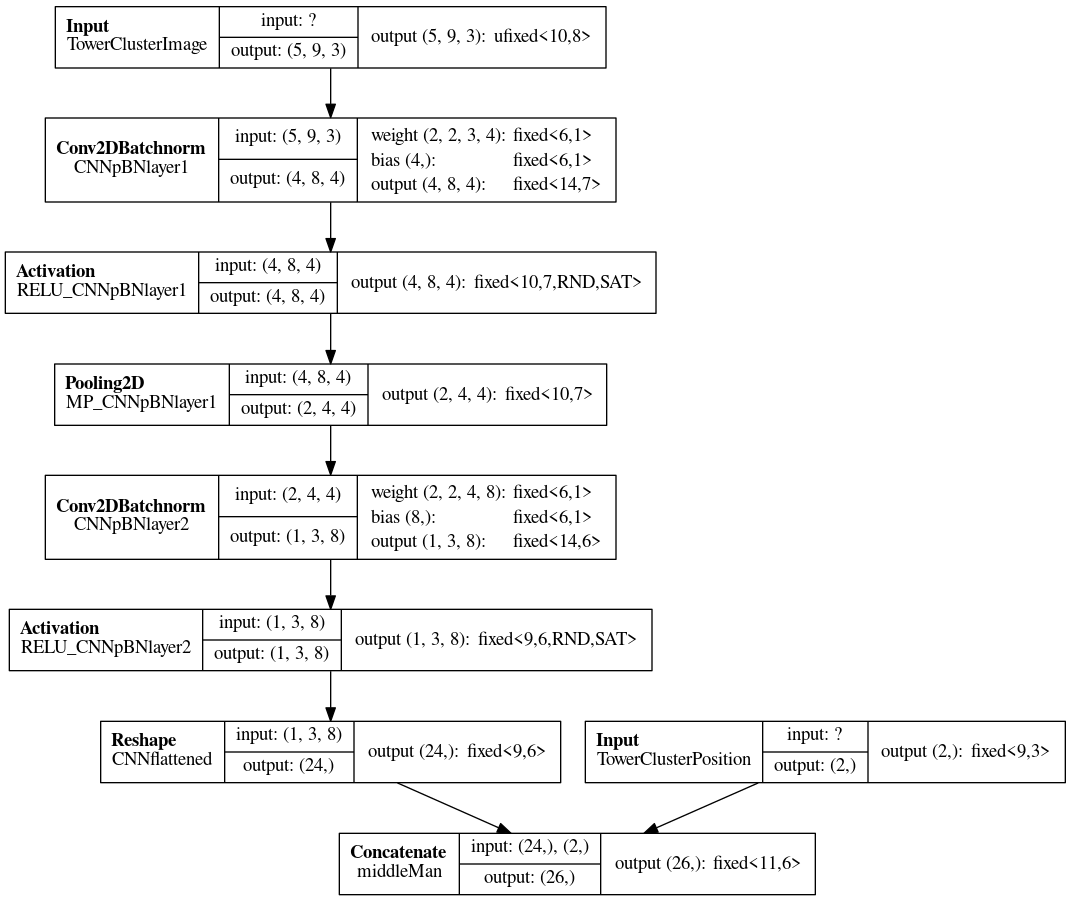

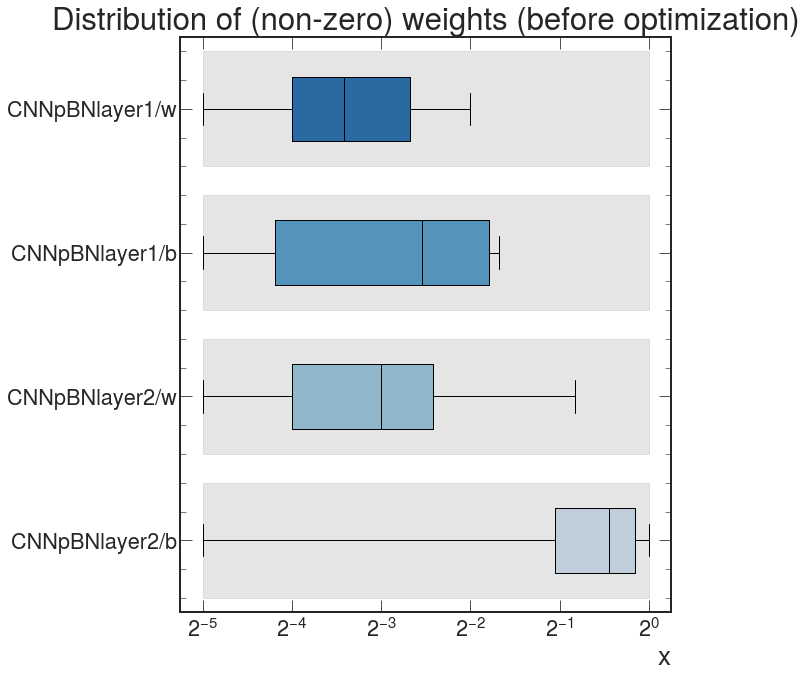

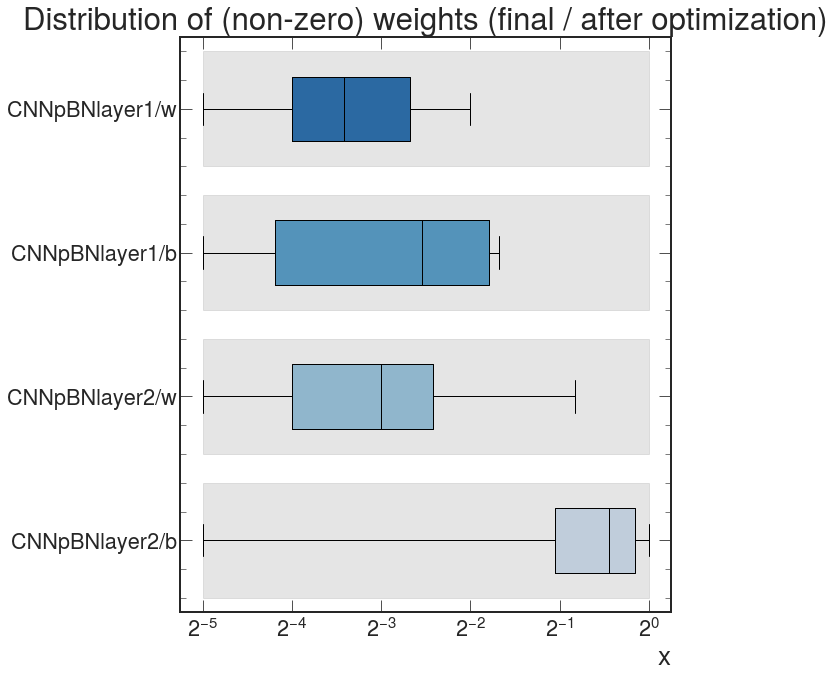

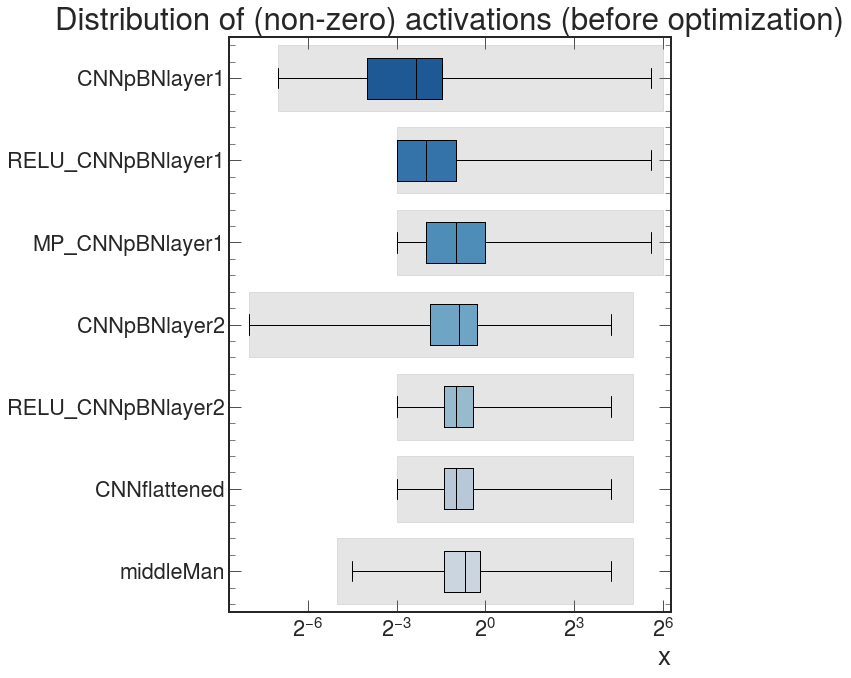

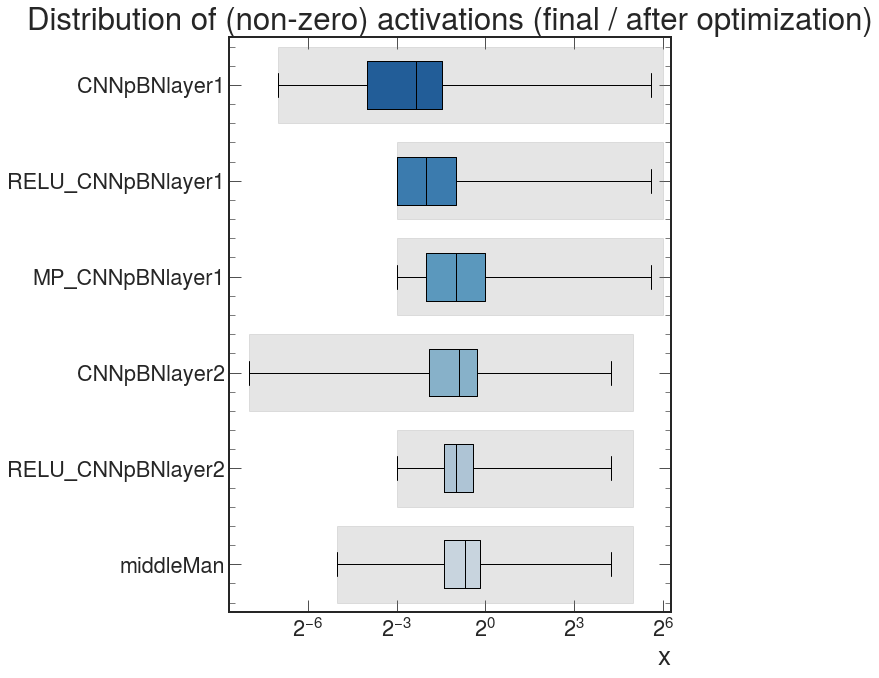

In [8]:
############################## Pass quantized CNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
QCNN_hls_cfg = hls4ml.utils.config_from_keras_model(QCNN, granularity='name')
QCNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
QCNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in QCNN_hls_cfg['LayerName'].keys():
    QCNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    QCNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    QCNN_hls_cfg['LayerName'][Layer]['Trace'] = True

QCNN_hls_cfg['LayerName']['TowerClusterImage']['Precision'] = 'ap_ufixed<10,8>'
QCNN_hls_cfg['LayerName']['TowerClusterPosition']['Precision'] = 'ap_fixed<9,3>'

QCNN_hls_cfg['LayerName']['CNNpBNlayer1']['ParallelizationFactor'] = 4
QCNN_hls_cfg['LayerName']['CNNpBNlayer1']['Precision']['result'] = 'ap_fixed<14,7>'
QCNN_hls_cfg['LayerName']['CNNpBNlayer1']['Precision']['accum'] = 'ap_fixed<14,7>'

QCNN_hls_cfg['LayerName']['RELU_CNNpBNlayer1']['Precision']['result'] = 'ap_fixed<10,7>'
QCNN_hls_cfg['LayerName']['RELU_CNNpBNlayer1']['Precision']['accum'] = 'ap_fixed<10,7>'

QCNN_hls_cfg['LayerName']['MP_CNNpBNlayer1']['Precision'] = 'ap_fixed<10,7>'

QCNN_hls_cfg['LayerName']['CNNpBNlayer2']['Precision']['result'] = 'ap_fixed<14,6>'
QCNN_hls_cfg['LayerName']['CNNpBNlayer2']['Precision']['accum'] = 'ap_fixed<14,6>'

QCNN_hls_cfg['LayerName']['RELU_CNNpBNlayer2']['Precision']['result'] = 'ap_fixed<9,6>'
QCNN_hls_cfg['LayerName']['RELU_CNNpBNlayer2']['Precision']['accum'] = 'ap_fixed<9,6>'

QCNN_hls_cfg['LayerName']['middleMan']['Precision'] = 'ap_fixed<11,6>'
QCNN_hls_cfg['LayerName']['middleMan']['Strategy'] = 'Stable'

print(QCNN_hls_cfg)

QCNN_cfg = hls4ml.converters.create_config(backend='Vivado')
QCNN_cfg['IOType']     = 'io_parallel' # Must set this if using CNNs!
QCNN_cfg['HLSConfig']  = QCNN_hls_cfg
QCNN_cfg['KerasModel'] = QCNN
QCNN_cfg['OutputDir']  = identdir+'/QCNNmodel'+sparsityTag+'Pruned_HLS/'
QCNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
QCNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QCNN_hls = hls4ml.converters.keras_to_hls(QCNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QCNN_hls.compile()

hls4ml.model.profiling.numerical(model=QCNN, hls_model=QCNN_hls, X=[X1_id_reduced,X2_id_reduced])
hls4ml.utils.plot_model(QCNN_hls, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: CNNflattened, layer type: Input
Layer name: DNNlayer1, layer type: QDense
  -> Activation (linear), layer name: DNNlayer1
Layer name: RELU_DNNlayer1, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_DNNlayer1
Layer name: DNNlayer2, layer type: QDense
  -> Activation (linear), layer name: DNNlayer2
Layer name: RELU_DNNlayer2, layer type: QActivation
  -> Activation (quantized_relu(8,5)), layer name: RELU_DNNlayer2
Layer name: DNNout, layer type: QDense
  -> Activation (linear), layer name: DNNout
Layer name: sigmoid_DNNout, layer type: Activation
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CNNflattened': {'Precision': 'ap_fixed<11,6>', 'Strategy': 'Resources', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer1': {'Precision': {'weight': 'ap_fixed<6,1>', 'result': 'ap_fixed<9,6>', 'accum': 'ap_fixed<13,5>'}, 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': True}, 'D

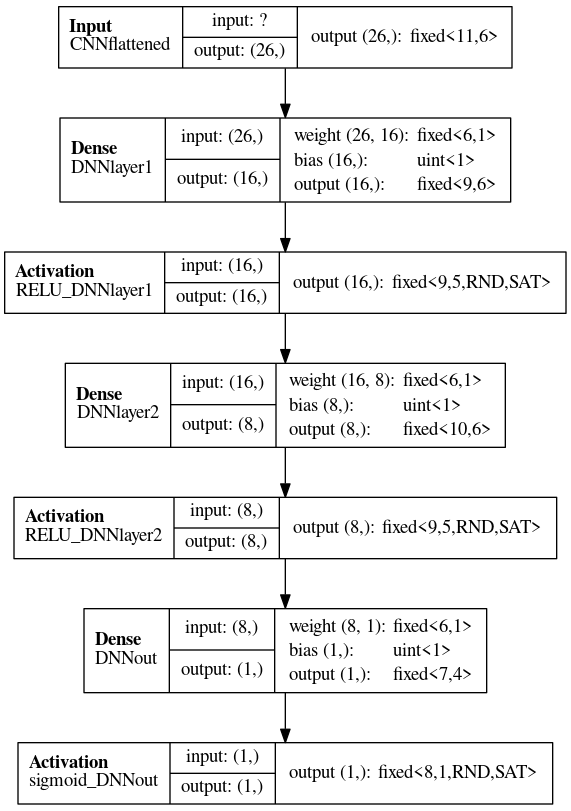

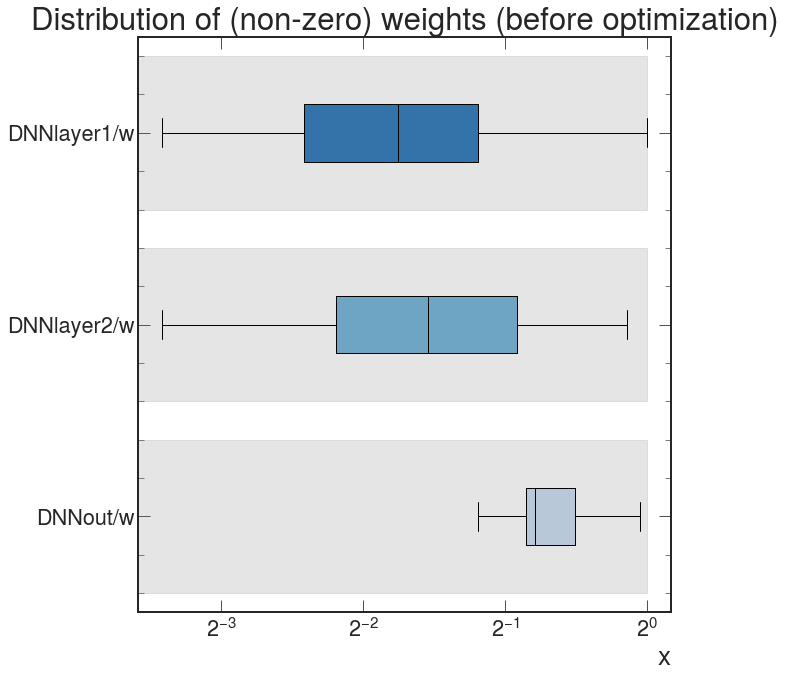

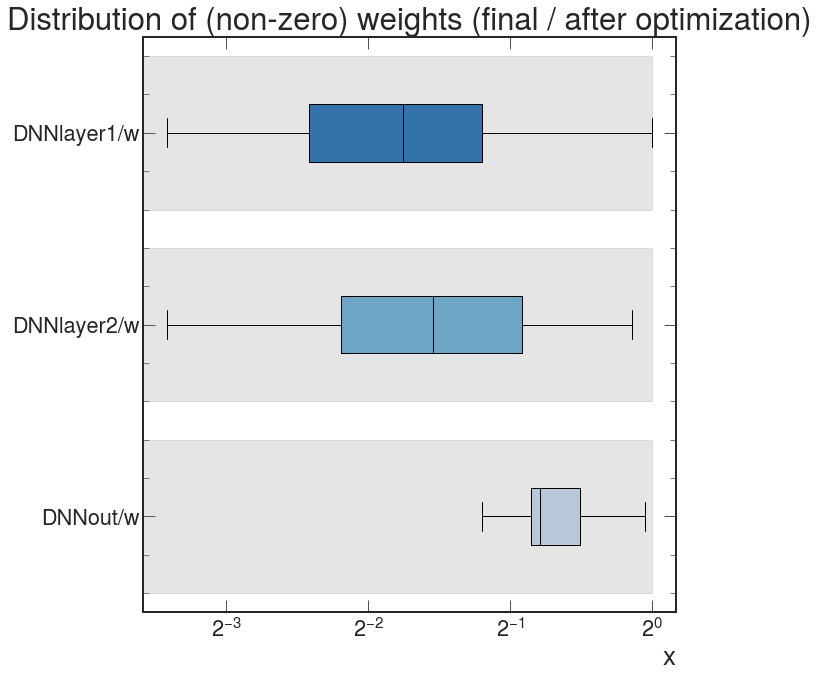

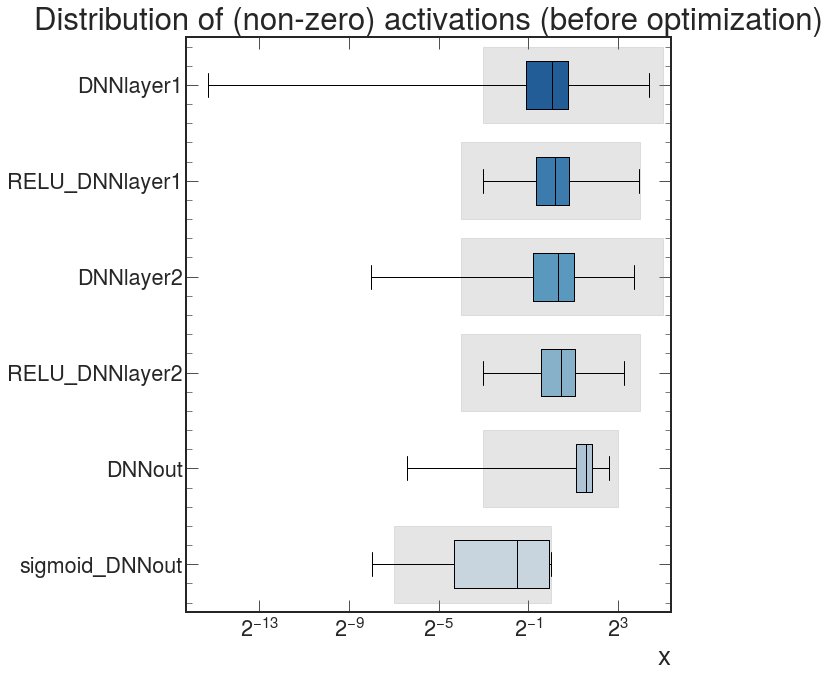

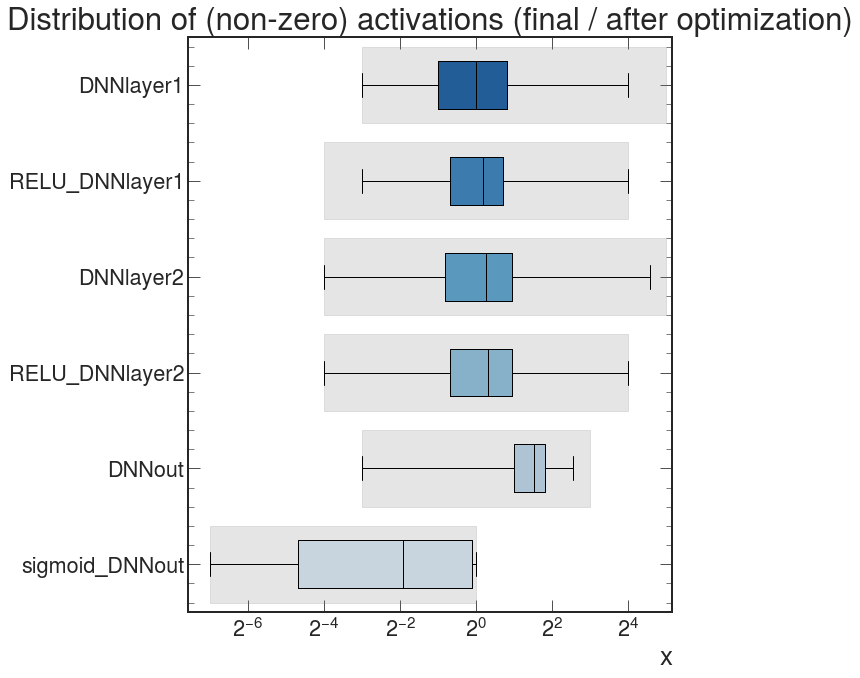

In [9]:
############################## Pass quantized identification DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
id_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNident, granularity='name')
id_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
id_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in id_QDNN_hls_cfg['LayerName'].keys():
    id_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Resources'
    id_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    id_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True

id_QDNN_hls_cfg['LayerName']['CNNflattened']['Precision'] = 'ap_fixed<11,6>'

id_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['result'] = 'ap_fixed<9,6>'
id_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['accum'] = 'ap_fixed<13,5>'
id_QDNN_hls_cfg['LayerName']['RELU_DNNlayer1']['Precision'] = 'ap_fixed<9,5>'

id_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['result'] = 'ap_fixed<10,6>'
id_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['accum'] = 'ap_fixed<11,6>'
id_QDNN_hls_cfg['LayerName']['RELU_DNNlayer2']['Precision'] = 'ap_fixed<9,5>'

id_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['result'] = 'ap_fixed<7,4>'
id_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['accum'] = 'ap_fixed<7,4>'

id_QDNN_hls_cfg['LayerName']['sigmoid_DNNout']['Precision'] = 'ap_fixed<8,1>'
id_QDNN_hls_cfg['LayerName']['sigmoid_DNNout']['Strategy'] = 'Stable'

print(id_QDNN_hls_cfg)

id_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
id_QDNN_cfg['IOType']     = 'io_stream'
id_QDNN_cfg['HLSConfig']  = id_QDNN_hls_cfg
id_QDNN_cfg['KerasModel'] = QDNNident
id_QDNN_cfg['OutputDir']  = identdir+'/QDNNmodel'+sparsityTag+'Pruned_HLS/'
id_QDNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
id_QDNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QDNNident_hls = hls4ml.converters.keras_to_hls(id_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNident_hls.compile()

id_QCNNoutput = np.array(QCNN([X1_id_reduced,X2_id_reduced]))

hls4ml.model.profiling.numerical(model=QDNNident, hls_model=QDNNident_hls, X=id_QCNNoutput)
hls4ml.utils.plot_model(QDNNident_hls, show_shapes=True, show_precision=True, to_file=None)

## Create HLS model for the calibration DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: CNNflattened, layer type: Input
Layer name: DNNlayer1, layer type: QDense
  -> Activation (linear), layer name: DNNlayer1
Layer name: RELU_DNNlayer1, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_DNNlayer1
Layer name: DNNlayer2, layer type: QDense
  -> Activation (linear), layer name: DNNlayer2
Layer name: RELU_DNNlayer2, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_DNNlayer2
Layer name: DNNout, layer type: QDense
  -> Activation (linear), layer name: DNNout
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CNNflattened': {'Precision': 'ap_fixed<11,6>', 'Strategy': 'Resources', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer1': {'Precision': {'weight': 'ap_fixed<6,1>', 'result': 'ap_fixed<16,7>', 'accum': 'ap_fixed<16,5>'}, 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': True}, 'DNNlayer1_linear': {'Precision': 'ap_fixed<16,6>', 

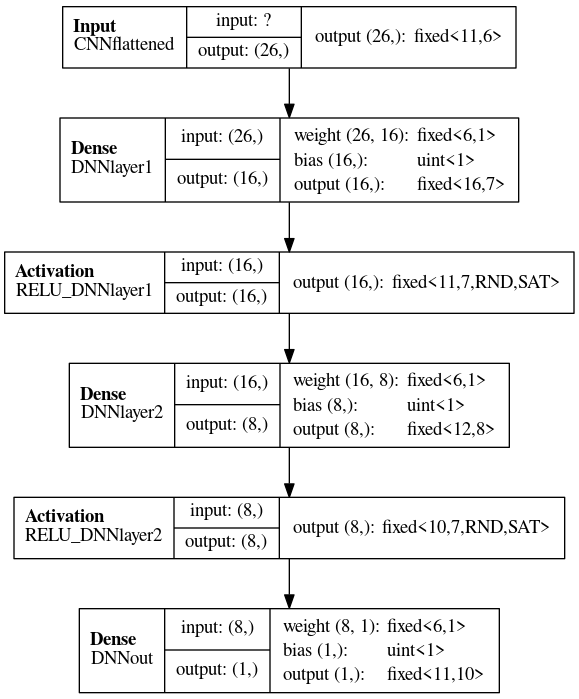

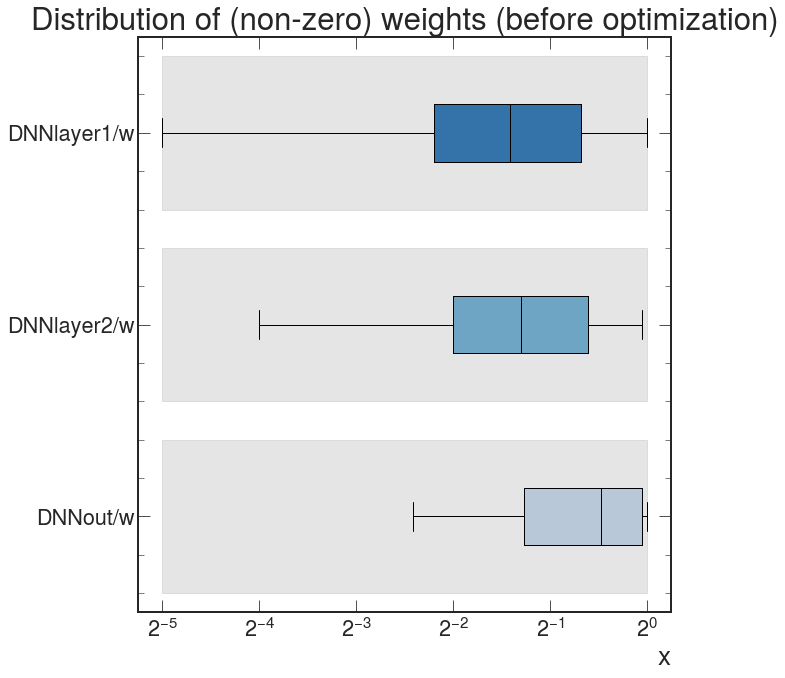

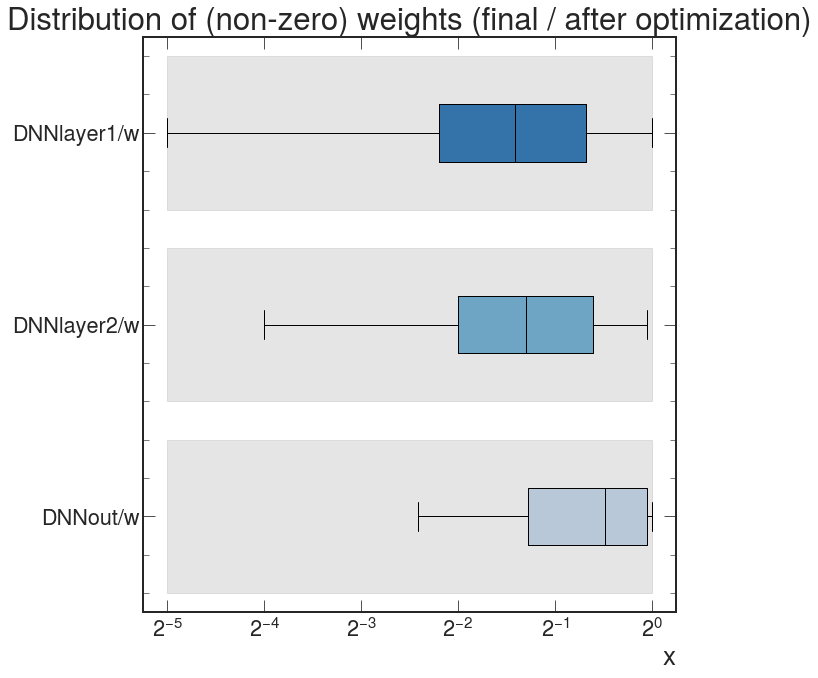

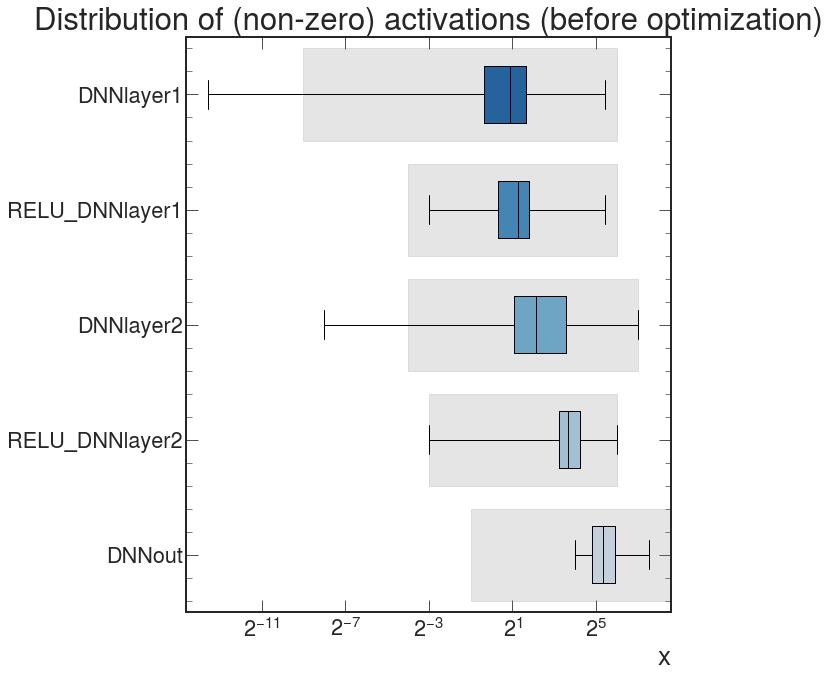

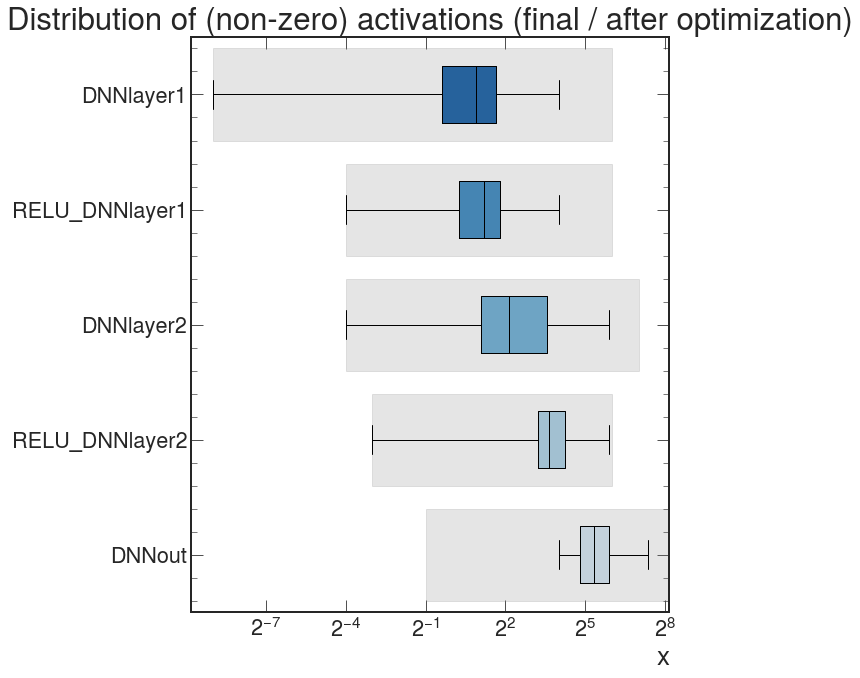

In [10]:
############################## Pass quantized calibration DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
cal_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNcalib, granularity='name')
cal_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
cal_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in cal_QDNN_hls_cfg['LayerName'].keys():
    cal_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Resources'
    cal_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    cal_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True

cal_QDNN_hls_cfg['LayerName']['CNNflattened']['Precision'] = 'ap_fixed<11,6>'
    
cal_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['result'] = 'ap_fixed<16,7>'
cal_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['accum'] = 'ap_fixed<16,5>'
cal_QDNN_hls_cfg['LayerName']['RELU_DNNlayer1']['Precision'] = 'ap_fixed<11,7>'

cal_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['result'] = 'ap_fixed<12,8>'
cal_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['accum'] = 'ap_fixed<16,7>'
cal_QDNN_hls_cfg['LayerName']['RELU_DNNlayer2']['Precision'] = 'ap_fixed<10,7>'

cal_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['result'] = 'ap_fixed<11,10>'
cal_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['accum'] = 'ap_fixed<16,9>'
cal_QDNN_hls_cfg['LayerName']['DNNout']['Strategy'] = 'Stable'

print(cal_QDNN_hls_cfg)

cal_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
cal_QDNN_cfg['IOType']     = 'io_stream'
cal_QDNN_cfg['HLSConfig']  = cal_QDNN_hls_cfg
cal_QDNN_cfg['KerasModel'] = QDNNcalib
cal_QDNN_cfg['OutputDir']  = calibdir+'/QDNNmodel'+sparsityTag+'Pruned_HLS/'
cal_QDNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
cal_QDNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QDNNcalib_hls = hls4ml.converters.keras_to_hls(cal_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNcalib_hls.compile()

cal_QCNNoutput = np.array(QCNN([X1_cal_reduced,X2_cal_reduced]))

hls4ml.model.profiling.numerical(model=QDNNcalib, hls_model=QDNNcalib_hls, X=cal_QCNNoutput)
hls4ml.utils.plot_model(QDNNcalib_hls, show_shapes=True, show_precision=True, to_file=None)

# COMPARE HLS TO KERAS AND QKERAS MODELS

In [11]:
def plotROC(Y, y_pred, y_pred_hls4ml, y_pred_fullfloat, label="Model", Xrange=None, Yrange=None, Yscale=None):    
    fig, ax = plt.subplots(figsize=(10, 10))

    FPR, TPR, THR = metrics.roc_curve(Y, y_pred)
    AUC = metrics.roc_auc_score(Y, y_pred)
    
    FPR_HLS, TPR_HLS, THR_HLS = metrics.roc_curve(Y, y_pred_hls4ml)
    AUC_HLS = metrics.roc_auc_score(Y, y_pred_hls4ml)
    
    FPR_FF, TPR_FF, THR_FF = metrics.roc_curve(Y, y_pred_fullfloat)
    AUC_FF = metrics.roc_auc_score(Y, y_pred_fullfloat)
    
    plt.plot(TPR_FF, FPR_FF, label='Keras Floating Point ROC, AUC = %.3f' % (AUC_FF), color='red',lw=2)
    plt.plot(TPR, FPR, label=label+' ROC, AUC = %.3f' % (AUC),   color='blue',lw=2)
    plt.plot(TPR_HLS, FPR_HLS, label='HLS Firmware ROC, AUC = %.3f' % (AUC_HLS), color='green',lw=2)
    
    plt.legend(loc = 'upper left', fontsize=24)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Efficiency')
    plt.grid(linestyle=':')
    if Xrange: plt.xlim(Xrange)
    if Yrange: plt.ylim(Yrange)
    if Yscale: plt.yscale(Yscale)
    mplhep.cms.label('Work in progress', data=True, rlabel='14 TeV, 200 PU')

In [12]:
y_ident_ff = DNNident_FullFloat.predict(CNN_FullFloat.predict([X1_id, X2_id]))
y_calib_ff = DNNcalib_FullFloat.predict(CNN_FullFloat.predict([X1_cal, X2_cal]))

In [13]:
y_ident_q        = QDNNident.predict(QCNN.predict([X1_id, X2_id]))
y_ident_hls4ml_q = QDNNident_hls.predict(QCNN_hls.predict([X1_id, X2_id]))

In [14]:
y_calib_q        = QDNNcalib.predict(QCNN.predict([X1_cal, X2_cal]))
y_calib_hls4ml_q = QDNNcalib_hls.predict(QCNN_hls.predict([X1_cal, X2_cal]))

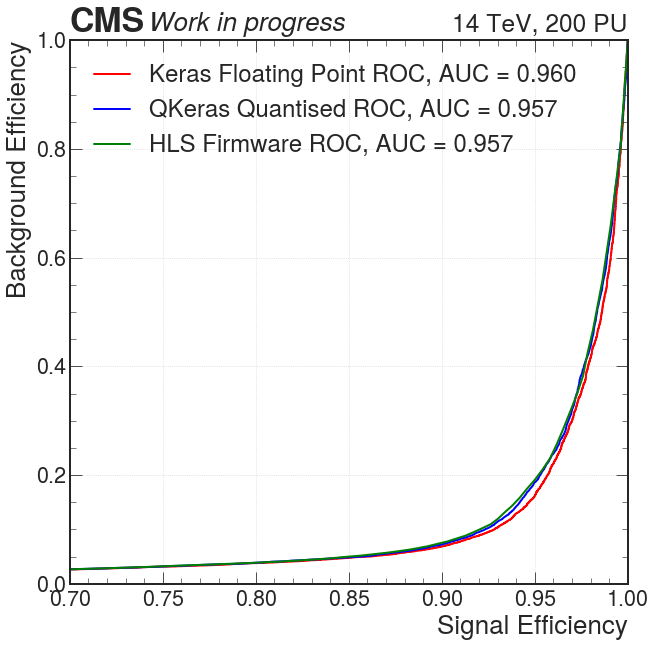

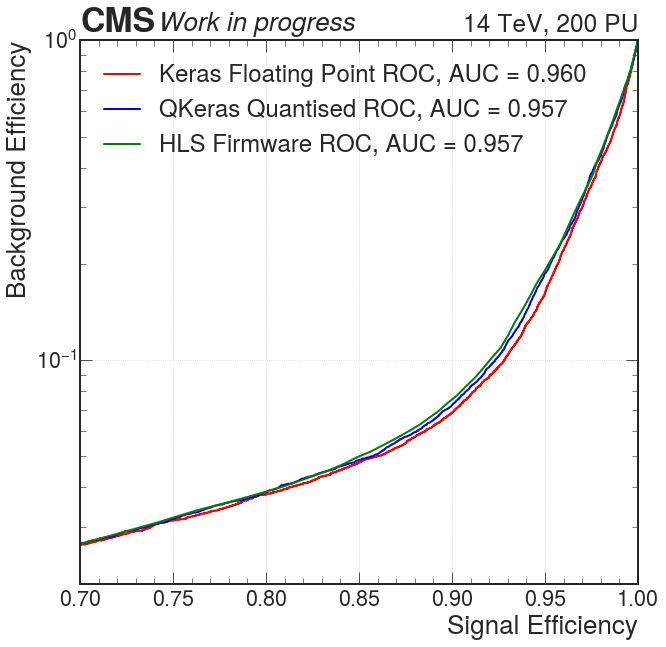

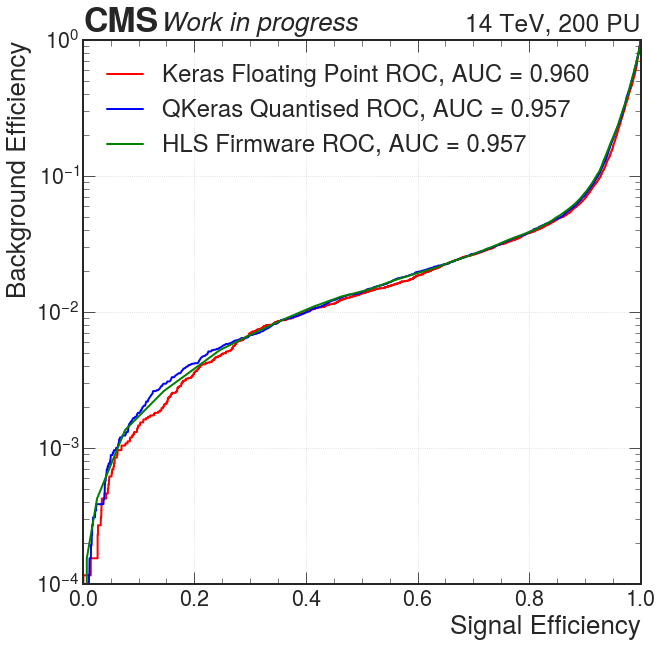

In [15]:
plotROC(Y_id,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras Quantised", Xrange=(0.7,1), Yrange=(0,1))
plotROC(Y_id,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras Quantised", Yscale="log", Xrange=(0.7,1), Yrange=(0.02,1))
plotROC(Y_id,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras Quantised", Yscale="log", Xrange=(0.,1), Yrange=(0.0001,1))

In [16]:
ravelled = Y_cal[:,0]

response_q = y_calib_q.ravel() / ravelled
response_q_hls4ml = y_calib_hls4ml_q.ravel() / ravelled
response_ff = y_calib_ff.ravel() / ravelled

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in progress'))

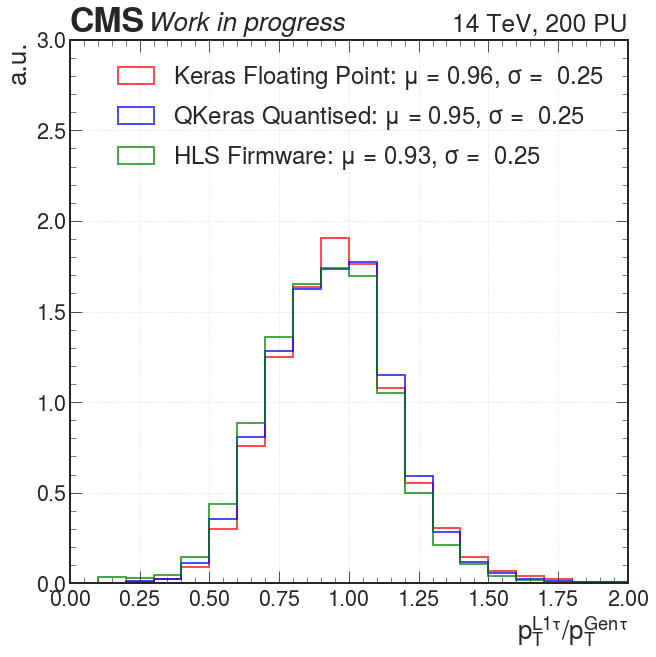

In [17]:
plt.figure(figsize=(10,10))
plt.hist(response_ff,       bins=np.arange(0,5,0.1), label=r'Keras Floating Point: $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_ff), np.std(response_ff)), color='red', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_q,        bins=np.arange(0,5,0.1), label=r'QKeras Quantised: $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q), np.std(response_q)), color='blue', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_q_hls4ml, bins=np.arange(0,5,0.1), label=r'HLS Firmware: $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q_hls4ml), np.std(response_q_hls4ml)), color='green', lw=2, density=True, histtype='step', alpha=0.7)
plt.xlabel(r'$p_{T}^{L1 \tau} / p_{T}^{Gen \tau}$')
plt.ylabel(r'a.u.')
plt.xlim(0., 2.)
plt.ylim(0., 3.)
plt.legend(loc = 'upper right', fontsize=24)
plt.grid(linestyle='dotted')
mplhep.cms.label('Work in progress', data=True, rlabel='14 TeV, 200 PU')

# SYNTHESISE HLS MODELS

In [18]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QCNN_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Thu Oct 06 19:03:40 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p25Pruned_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/data__data.polcms/cms/motta/Phase

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:25 ; elapsed = 00:00:29 . Memory (MB): peak = 1117.398 ; gain = 595.309 ; free physical = 322884 ; free virtual = 374387
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::concatenate1d<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>' (firmware/nnet_utils/nnet_merge.h:170:44).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<14, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config6>' (firmware/nnet_utils/nnet_activation.h:66:39).
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'PartitionLoop' (firmware/nnet_utils/nnet_conv2d_latency.h:196) in function 'nnet::conv_2d_cl<ap_fixed<10, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<14, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>' for pipelining.
INFO:

INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:59) automatically.
INFO: [XFORM 203-602] Inlining function 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' into 'generic_cast_IEEE754<int, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/Float

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:00:50 ; elapsed = 00:00:55 . Memory (MB): peak = 1369.254 ; gain = 847.164 ; free physical = 322659 ; free virtual = 374170
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'fill_buffer' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'fill_buffer'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 54.85 seconds; current allocated memory: 466.957 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource shari

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'myproject' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.15 seconds; current allocated memory: 534.851 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 4.31 seconds; current allocated memory: 538.877 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'fill_buffer' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-1

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_1_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_2_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_3_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_4_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_5_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_6_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_7_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_8_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_9_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_10_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_86_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_87_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_88_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_89_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_90_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_91_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_92_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_93_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_94_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_95_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_44_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_45_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_46_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_47_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_48_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_49_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_50_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_51_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_52_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_53_V_U(fifo_w9_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO '

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_4_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_5_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_6_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_7_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_8_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_9_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_10_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_11_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_12_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_13_V_U(fifo_w10_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FI

INFO: [Common 17-349] Got license for feature 'Synthesis' and/or device 'xcvu13p'
INFO: Launching helper process for spawning children vivado processes
INFO: Helper process launched with PID 13684 
---------------------------------------------------------------------------------
Starting Synthesize : Time (s): cpu = 00:00:03 ; elapsed = 00:00:05 . Memory (MB): peak = 1841.422 ; gain = 217.523 ; free physical = 321443 ; free virtual = 373110
---------------------------------------------------------------------------------
INFO: [Synth 8-638] synthesizing module 'myproject' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:79]
INFO: [Synth 8-3491] module 'conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p25Pruned_HLS/myproject_prj/solut

	Parameter din108_WIDTH bound to: 1 - type: integer 
	Parameter din109_WIDTH bound to: 1 - type: integer 
	Parameter din110_WIDTH bound to: 1 - type: integer 
	Parameter din111_WIDTH bound to: 1 - type: integer 
	Parameter din112_WIDTH bound to: 1 - type: integer 
	Parameter din113_WIDTH bound to: 1 - type: integer 
	Parameter din114_WIDTH bound to: 1 - type: integer 
	Parameter din115_WIDTH bound to: 1 - type: integer 
	Parameter din116_WIDTH bound to: 1 - type: integer 
	Parameter din117_WIDTH bound to: 1 - type: integer 
	Parameter din118_WIDTH bound to: 1 - type: integer 
	Parameter din119_WIDTH bound to: 1 - type: integer 
	Parameter din120_WIDTH bound to: 1 - type: integer 
	Parameter din121_WIDTH bound to: 1 - type: integer 
	Parameter din122_WIDTH bound to: 1 - type: integer 
	Parameter din123_WIDTH bound to: 1 - type: integer 
	Parameter din124_WIDTH bound to: 1 - type: integer 
	Parameter din125_WIDTH bound to: 1 - type: integer 
	Parameter din126_WIDTH bound to: 1 - type: in

INFO: [Synth 8-3491] module 'myproject_mux_1287_1_1_1' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/myproject_mux_1287_1_1_1.vhd:10' bound to instance 'myproject_mux_1287_1_1_1_U90' of component 'myproject_mux_1287_1_1_1' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596.vhd:12603]
	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH boun

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH bound to: 1 - type: integer 
	Parameter din7_WIDTH bound to: 1 - type: integer 
	Parameter din8_WIDTH bound to: 1 - type: integer 
	Parameter din9_WIDTH bound to: 1 - type: integer 
	Parameter din10_WIDTH bound to: 1 - type: integer 
	Parameter din11_WIDTH bound to: 1 - type: integer 
	Parameter din12_WIDTH bound to: 1 - type: integer 
	Parameter din13_WIDTH bound to: 1 - type: integer 
	Parameter din14_WIDTH bound to: 1 - type: integer 
	Parameter din15_WIDTH bound to: 1 - type: integer 
	Parameter din16_WIDTH bound to: 1 - type: integer 
	Parameter din17_WIDTH bound to: 

	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH bound to: 1 - type: integer 
	Parameter din7_WIDTH bound to: 1 - type: integer 
	Parameter din8_WIDTH bound to: 1 - type: integer 
	Parameter din9_WIDTH bound to: 1 - type: integer 
	Parameter din10_WIDTH bound to: 1 - type: integer 
	Parameter din11_WIDTH bound to: 1 - type: integer 
	Parameter din12_WIDTH bound to: 1 - type: integer 
	Parameter din13_WIDTH bound to: 1 - type: integer 
	Parameter din14_WIDTH bound to: 1 - type: integer 
	Parameter din15_WIDTH bound to: 1 - type: integer 
	Parameter din16_WIDTH bound to: 1 - type: integer 
	Parameter din17_WIDTH bound to: 1 - type: integer 
	Parameter din18_WIDTH b

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH bound to: 1 - type: integer 
	Parameter din7_WIDTH bound to: 1 - type: integer 
	Parameter din8_WIDTH bound to: 1 - type: integer 
	Parameter din9_WIDTH bound to: 1 - type: integer 
	Parameter din10_WIDTH bound to: 1 - type: integer 
	Parameter din11_WIDTH bound to: 1 - type: integer 
	Parameter din12_WIDTH bound to: 1 - type: integer 
	Parameter din13_WIDTH bound to: 1 - type: integer 
	Parameter din14_WIDTH bound to: 1 - type: integer 
	Parameter din15_WIDTH bound to: 1 - type: integer 
	Parameter din16_WIDTH bound to: 1 - type: integer 
	Parameter din17_WIDTH bound to: 

	Parameter din66_WIDTH bound to: 14 - type: integer 
	Parameter din67_WIDTH bound to: 14 - type: integer 
	Parameter din68_WIDTH bound to: 14 - type: integer 
	Parameter din69_WIDTH bound to: 14 - type: integer 
	Parameter din70_WIDTH bound to: 14 - type: integer 
	Parameter din71_WIDTH bound to: 14 - type: integer 
	Parameter din72_WIDTH bound to: 14 - type: integer 
	Parameter din73_WIDTH bound to: 14 - type: integer 
	Parameter din74_WIDTH bound to: 14 - type: integer 
	Parameter din75_WIDTH bound to: 14 - type: integer 
	Parameter din76_WIDTH bound to: 14 - type: integer 
	Parameter din77_WIDTH bound to: 14 - type: integer 
	Parameter din78_WIDTH bound to: 14 - type: integer 
	Parameter din79_WIDTH bound to: 14 - type: integer 
	Parameter din80_WIDTH bound to: 14 - type: integer 
	Parameter din81_WIDTH bound to: 14 - type: integer 
	Parameter din82_WIDTH bound to: 14 - type: integer 
	Parameter din83_WIDTH bound to: 14 - type: integer 
	Parameter din84_WIDTH bound to: 14 - type: in

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 14 - type: integer 
	Parameter din1_WIDTH bound to: 14 - type: integer 
	Parameter din2_WIDTH bound to: 14 - type: integer 
	Parameter din3_WIDTH bound to: 14 - type: integer 
	Parameter din4_WIDTH bound to: 14 - type: integer 
	Parameter din5_WIDTH bound to: 14 - type: integer 
	Parameter din6_WIDTH bound to: 14 - type: integer 
	Parameter din7_WIDTH bound to: 14 - type: integer 
	Parameter din8_WIDTH bound to: 14 - type: integer 
	Parameter din9_WIDTH bound to: 14 - type: integer 
	Parameter din10_WIDTH bound to: 14 - type: integer 
	Parameter din11_WIDTH bound to: 14 - type: integer 
	Parameter din12_WIDTH bound to: 14 - type: integer 
	Parameter din13_WIDTH bound to: 14 - type: integer 
	Parameter din14_WIDTH bound to: 14 - type: integer 
	Parameter din15_WIDTH bound to: 14 - type: integer 
	Parameter din16_WIDTH bound to: 14 - type: integer 
	Parameter din17

	Parameter din68_WIDTH bound to: 14 - type: integer 
	Parameter din69_WIDTH bound to: 14 - type: integer 
	Parameter din70_WIDTH bound to: 14 - type: integer 
	Parameter din71_WIDTH bound to: 14 - type: integer 
	Parameter din72_WIDTH bound to: 14 - type: integer 
	Parameter din73_WIDTH bound to: 14 - type: integer 
	Parameter din74_WIDTH bound to: 14 - type: integer 
	Parameter din75_WIDTH bound to: 14 - type: integer 
	Parameter din76_WIDTH bound to: 14 - type: integer 
	Parameter din77_WIDTH bound to: 14 - type: integer 
	Parameter din78_WIDTH bound to: 14 - type: integer 
	Parameter din79_WIDTH bound to: 14 - type: integer 
	Parameter din80_WIDTH bound to: 14 - type: integer 
	Parameter din81_WIDTH bound to: 14 - type: integer 
	Parameter din82_WIDTH bound to: 14 - type: integer 
	Parameter din83_WIDTH bound to: 14 - type: integer 
	Parameter din84_WIDTH bound to: 14 - type: integer 
	Parameter din85_WIDTH bound to: 14 - type: integer 
	Parameter din86_WIDTH bound to: 14 - type: in

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 14 - type: integer 
	Parameter din1_WIDTH bound to: 14 - type: integer 
	Parameter din2_WIDTH bound to: 14 - type: integer 
	Parameter din3_WIDTH bound to: 14 - type: integer 
	Parameter din4_WIDTH bound to: 14 - type: integer 
	Parameter din5_WIDTH bound to: 14 - type: integer 
	Parameter din6_WIDTH bound to: 14 - type: integer 
	Parameter din7_WIDTH bound to: 14 - type: integer 
	Parameter din8_WIDTH bound to: 14 - type: integer 
	Parameter din9_WIDTH bound to: 14 - type: integer 
	Parameter din10_WIDTH bound to: 14 - type: integer 
	Parameter din11_WIDTH bound to: 14 - type: integer 
	Parameter din12_WIDTH bound to: 14 - type: integer 
	Parameter din13_WIDTH bound to: 14 - type: integer 
	Parameter din14_WIDTH bound to: 14 - type: integer 
	Parameter din15_WIDTH bound to: 14 - type: integer 
	Parameter din16_WIDTH bound to: 14 - type: integer 
	Parameter din17

	Parameter din102_WIDTH bound to: 14 - type: integer 
	Parameter din103_WIDTH bound to: 14 - type: integer 
	Parameter din104_WIDTH bound to: 14 - type: integer 
	Parameter din105_WIDTH bound to: 14 - type: integer 
	Parameter din106_WIDTH bound to: 14 - type: integer 
	Parameter din107_WIDTH bound to: 14 - type: integer 
	Parameter din108_WIDTH bound to: 14 - type: integer 
	Parameter din109_WIDTH bound to: 14 - type: integer 
	Parameter din110_WIDTH bound to: 14 - type: integer 
	Parameter din111_WIDTH bound to: 14 - type: integer 
	Parameter din112_WIDTH bound to: 14 - type: integer 
	Parameter din113_WIDTH bound to: 14 - type: integer 
	Parameter din114_WIDTH bound to: 14 - type: integer 
	Parameter din115_WIDTH bound to: 14 - type: integer 
	Parameter din116_WIDTH bound to: 14 - type: integer 
	Parameter din117_WIDTH bound to: 14 - type: integer 
	Parameter din118_WIDTH bound to: 14 - type: integer 
	Parameter din119_WIDTH bound to: 14 - type: integer 
	Parameter din120_WIDTH boun

INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596' (4#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596.vhd:159]
INFO: [Synth 8-638] synthesizing module 'relu_ap_fixed_ap_fixed_10_7_0_0_0_relu_config3_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_10_7_0_0_0_relu_config3_s.vhd:280]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_10_7_0_0_0_relu_config3_s.vhd:296]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid

	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 14 - type: integer 
	Parameter din1_WIDTH bound to: 14 - type: integer 
	Parameter din2_WIDTH bound to: 14 - type: integer 
	Parameter din3_WIDTH bound to: 14 - type: integer 
	Parameter din4_WIDTH bound to: 14 - type: integer 
	Parameter din5_WIDTH bound to: 14 - type: integer 
	Parameter din6_WIDTH bound to: 14 - type: integer 
	Parameter din7_WIDTH bound to: 14 - type: integer 
	Parameter din8_WIDTH bound to: 14 - type: integer 
	Parameter din9_WIDTH bound to: 14 - type: integer 
	Parameter din10_WIDTH bound to: 14 - type: integer 
	Parameter din11_WIDTH bound to: 14 - type: integer 
	Parameter din12_WIDTH bound to: 14 - type: integer 
	Parameter din13_WIDTH bound to: 14 - type: integer 
	Parameter din14_WIDTH bound to: 14 - type: integer 
	Parameter din15_WIDTH bound to: 14 - type: integer 
	Parameter din16_WIDTH bound to: 14 - type: integer 
	Parameter din17_WIDTH bound to: 14 - type: integer 
	Param

INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_ap_fixed_ap_fixed_14_6_5_3_0_config5_s' (11#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_14_6_5_3_0_config5_s.vhd:80]
INFO: [Synth 8-638] synthesizing module 'relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config6_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config6_s.vhd:72]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config6_s.vhd:88]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__

INFO: [Synth 8-256] done synthesizing module 'myproject' (24#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:79]
---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:16 ; elapsed = 00:00:19 . Memory (MB): peak = 2071.754 ; gain = 447.855 ; free physical = 321303 ; free virtual = 372979
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:17 ; elapsed = 00:00:21 . Memory (MB): peak = 2086.590 ; gain = 462.691 ; free physical = 321317 ; free virtual = 372992
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start 

+---Registers : 
	               14 Bit    Registers := 2     
+---Muxes : 
	   2 Input     14 Bit        Muxes := 1     
Module fifo_w14_d2_A__12 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w14_d2_A_shiftReg__13 
Detailed RTL Component Info : 
+---Registers : 
	               14 Bit    Registers := 2     
+---Muxes : 
	   2 Input     14 Bit        Muxes := 1     
Module fifo_w14_d2_A__13 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w14_d2_A_shiftReg__14 
Detailed RTL Component Info : 
+---Registers : 
	               14 Bit    Registers :

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
INFO: [Synth 8-5580] Multithreading enabled for synth_design using a maximum of 4 processes.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
INFO: [Synth 8-3333] propagating constant 0 across sequential element (add_ln202_fu_3746_p2_inferred/\p_077_i_idx_i_i_reg_3272_reg[0] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (add_ln202_fu_3746_p2_inferred/\p_077_i_idx_i_i_reg_3272_reg[1] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (add_ln202_fu_3746_p2_inferred/\p_077_i_idx_i_i_reg_3272_reg[2] )
INFO:


Report RTL Partitions: 
+------+-----------------------------------------------------------+------------+----------+
|      |RTL Partition                                              |Replication |Instances |
+------+-----------------------------------------------------------+------------+----------+
|1     |conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596__GB0  |           1|     13163|
|2     |conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596__GB1  |           1|      2406|
|3     |conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596__GB2  |           1|       260|
|4     |conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596__GB3  |           1|       373|
|5     |conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596__GB4  |           1|       523|
|6     |conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596__GB5  |           1|       755|
|7     |conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_3_0_config2_596__GB6  |           1|       397|
|8     |conv_2d_cl_ap_ufixed_ap_fixed_14_7_5_

---------------------------------------------------------------------------------
Finished Rebuilding User Hierarchy : Time (s): cpu = 00:01:33 ; elapsed = 00:02:52 . Memory (MB): peak = 3286.562 ; gain = 1662.664 ; free physical = 313763 ; free virtual = 365721
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Renaming Generated Ports
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Renaming Generated Ports : Time (s): cpu = 00:01:33 ; elapsed = 00:02:52 . Memory (MB): peak = 3286.562 ; gain = 1662.664 ; free physical = 313763 ; free virtual = 365721
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Handling Custom Attributes
-

Synthesis Optimization Runtime : Time (s): cpu = 00:01:36 ; elapsed = 00:02:57 . Memory (MB): peak = 3286.562 ; gain = 1662.664 ; free physical = 320056 ; free virtual = 372015
Synthesis Optimization Complete : Time (s): cpu = 00:01:36 ; elapsed = 00:02:57 . Memory (MB): peak = 3286.562 ; gain = 1662.664 ; free physical = 320063 ; free virtual = 372014
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.28 ; elapsed = 00:00:00.28 . Memory (MB): peak = 3286.562 ; gain = 0.000 ; free physical = 320069 ; free virtual = 372020
INFO: [Netlist 29-17] Analyzing 2006 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:00.01 . Memory (MB): peak = 3353.449 ; gain = 0.000 ; free physical = 319949 ; free v

In [19]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QDNNident_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Thu Oct 06 19:10:11 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QDNNmodel0p25Pruned_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/data__data.polcms/cms/motta/Phase

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:22 ; elapsed = 00:00:26 . Memory (MB): peak = 1054.730 ; gain = 532.641 ; free physical = 322718 ; free virtual = 374424
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.

INFO: [HLS 200-489] Unrolling loop 'Product1' (firmware/nnet_utils/nnet_dense_latency.h:59) in function 'nnet::dense_wrapper<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 26.
INFO: [HLS 200-489] Unrolling loop 'Product2' (firmware/nnet_utils/nnet_dense_latency.h:61) in function 'nnet::dense_wrapper<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:68) in function 'nnet::dense_wrapper<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:73) in function 'nnet::dense_wrapper<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3

INFO: [XFORM 203-712] Applying dataflow to function 'myproject', detected/extracted 6 process function(s): 
	 'nnet::dense<nnet::array<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 26u>, nnet::array<ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config2>'
	 'nnet::relu<nnet::array<ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<9, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, relu_config3>'
	 'nnet::dense<nnet::array<ap_fixed<9, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<10, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, config4>'
	 'nnet::relu<nnet::array<ap_fixed<10, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, nnet::array<ap_fixed<9, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>, relu_config5>'
	 'nnet::dense<nnet::array<ap_fixed<9, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>, nnet::array<ap_fixed<7, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config6>'
	 'nnet::sigmoid<nnet::array<ap_fixed<7, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<8, 1, (ap

INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.27 seconds; current allocated memory: 395.532 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_array_ap_fixed_16u_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<array,array<ap_fixed,16u>,relu_config3>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.76 seconds; current allocated memory: 396.291 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architec

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_array_ap_fixed_16u_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_array_ap_fixed_16u_relu_config3_s'.
INFO: [HLS 200-111]  Elapsed time: 0.98 seconds; current allocated memory: 438.344 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_wrapper_ap_fixed_ap_fixed_10_6_5_3_0_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_wrapper_ap_fixed_ap_fixed_10_6_5_3_0_config4_s'.
INFO: [HLS 200-111]  Elapsed time: 0.7 seconds; current allocated memory: 443.824 MB.
INFO: [HLS 200-10] ------------------------------------------------------------

INFO: [HLS 200-111] Finished generating all RTL models Time (s): cpu = 00:00:53 ; elapsed = 00:01:04 . Memory (MB): peak = 1397.258 ; gain = 875.168 ; free physical = 322380 ; free virtual = 374138
INFO: [VHDL 208-304] Generating VHDL RTL for myproject.
INFO: [VLOG 209-307] Generating Verilog RTL for myproject.
***** C/RTL SYNTHESIS COMPLETED IN 0h1m0s *****
***** VIVADO SYNTHESIS *****

****** Vivado v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source vivado_synth.tcl
# add_files myproject_prj/solution1/syn/vhdl
# synth_design -top myproject -part xcvu13p-fhgb2104-2L-e
Command: synth_design -top myproject -part xcvu13p-fhgb2104-2L-e
Starting synth_design
Attempting to get a license for feature 'Synthesis' and/or device 'xcvu13p'
INFO: [Common 17-349] Got license for feature 'Synthesis' and/or device 'xcvu13p'
INFO: Launching helper process f

INFO: [Synth 8-256] done synthesizing module 'dense_wrapper_ap_fixed_ap_fixed_10_6_5_3_0_config4_s' (7#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QDNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/dense_wrapper_ap_fixed_ap_fixed_10_6_5_3_0_config4_s.vhd:42]
INFO: [Synth 8-256] done synthesizing module 'dense_array_array_ap_fixed_10_6_5_3_0_8u_config4_s' (8#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QDNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/dense_array_array_ap_fixed_10_6_5_3_0_8u_config4_s.vhd:99]
INFO: [Synth 8-3491] module 'relu_array_array_ap_fixed_8u_relu_config5_s' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QDNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/relu_array_array_ap_fixed_8u_relu_config5_s.vhd:12' bound to instance 'relu_array_array_ap_fixed_8u_r

INFO: [Synth 8-256] done synthesizing module 'start_for_relu_array_array_ap_fixed_16u_relu_config3_U0' (22#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QDNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/start_for_relu_array_array_ap_fixed_16u_relu_config3_U0.vhd:66]
INFO: [Synth 8-3491] module 'start_for_dense_array_array_ap_fixed_10_6_5_3_0_8u_configcud' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QDNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/start_for_dense_array_array_ap_fixed_10_6_5_3_0_8u_configcud.vhd:47' bound to instance 'start_for_dense_array_array_ap_fixed_10_6_5_3_0_8u_configcud_U' of component 'start_for_dense_array_array_ap_fixed_10_6_5_3_0_8u_configcud' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNIdentifier5x9Training_lTauPtCut18/QDNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/myproject.vh

---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:05 ; elapsed = 00:00:08 . Memory (MB): peak = 1915.469 ; gain = 291.375 ; free physical = 321785 ; free virtual = 373545
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:06 ; elapsed = 00:00:09 . Memory (MB): peak = 1930.305 ; gain = 306.211 ; free physical = 321777 ; free virtual = 373538
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and Timing Information
---------------------------------------------------------------------------------
Loading part: xcvu13p-fhgb2104-2L-e
INFO: [Synth 8-6742] Reading net delay rules and data
-----------------------------------

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
No constraint files found.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_24_fu_414_p2, operation Mode is: A*(B:0x3ffe9).
DSP Report: operator mul_ln1118_24_fu_414_p2 is absorbed into DSP mul_ln1118_24_fu_414_p2.
DSP Report: Generating DSP mul_ln1118_33_fu_546_p2, operation Mode is: A*(B:0x13).
DSP Report: operator mul_ln1118_33_fu_546_p2 is absorbed into DSP mul_ln1118_33_fu_546_p2.
DSP Report: Generating DSP mul_ln1118_27_fu_338_p2, operation Mode is: A*(B:0x3ffe6).
DSP Report: operator mul_ln1118_27_fu_338_

INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer3_out_V_data_2_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][8] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer3_out_V_data_14_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][8] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer3_out_V_data_10_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][8] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer3_out_V_data_3_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][8] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer3_out_V_data_15_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][8] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer3_out_V_data_13_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][8] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer3_out_V_data_12_V_U/U_fifo_w9_d1_A_shiftReg/SRL_SIG_reg[0][8] )
INFO: [Synth 8-

INFO: [Synth 8-3333] propagating constant 0 across sequential element (\dense_array_array_ap_fixed_10_6_5_3_0_8u_config4_U0/data_0_V_reg_538_reg[0] )
---------------------------------------------------------------------------------
Finished Cross Boundary and Area Optimization : Time (s): cpu = 00:00:39 ; elapsed = 00:00:59 . Memory (MB): peak = 2934.285 ; gain = 1310.191 ; free physical = 320741 ; free virtual = 372512
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start ROM, RAM, DSP and Shift Register Reporting
---------------------------------------------------------------------------------

ROM:
+--------------------------------------------------+--------------------------------------------------------------------------------------------+---------------+----------------+
|Module Name                                       | RTL Object                                 

---------------------------------------------------------------------------------
Finished Final Netlist Cleanup
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished IO Insertion : Time (s): cpu = 00:00:46 ; elapsed = 00:01:07 . Memory (MB): peak = 2942.297 ; gain = 1318.203 ; free physical = 320745 ; free virtual = 372516
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Renaming Generated Instances
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Renaming Generated Instances : Time (s): cpu = 00:00:46 ; elapsed = 00:01:07 . Memory (MB): peak = 2942.297 ; gain = 1318.203 ; free physical = 320716 ; free virtual = 372487
--------

INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.15 ; elapsed = 00:00:00.15 . Memory (MB): peak = 2942.309 ; gain = 0.000 ; free physical = 320813 ; free virtual = 372583
INFO: [Netlist 29-17] Analyzing 1410 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:00 . Memory (MB): peak = 3049.941 ; gain = 0.000 ; free physical = 320664 ; free virtual = 372434
INFO: [Project 1-111] Unisim Transformation Summary:
  A total of 338 instances were transformed.
  BUFG => BUFGCE: 1 instance 
  DSP48E2 => DSP48E2 (DSP_ALU, DSP_A_B_DATA, DSP_C_DATA, DSP_MULTIPLIER, DSP_M_DATA, DSP_OUTPUT, DSP_PREADD, DSP_PREADD_DATA): 21 instances
  IBUF => IBUF (IBUFCTRL, INBUF): 316 instances

INFO: [Common 17-83] Rele

In [20]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QDNNcalib_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Thu Oct 06 19:13:11 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p25Pruned_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/data__data.polcms/cms/

INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:59) automatically.
INFO: [XFORM 203-602] Inlining function 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' into 'generic_cast_IEEE754<int, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/Float

INFO: [HLS 200-489] Unrolling loop 'Product2' (firmware/nnet_utils/nnet_dense_latency.h:61) in function 'nnet::dense_wrapper<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:68) in function 'nnet::dense_wrapper<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:73) in function 'nnet::dense_wrapper<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 26.
INFO: [HLS 200-489] Unrolling loop 'Accum2' (firmware/nnet_utils/nnet_dense_latency.h:74) in function 'nnet::dense_wrapper<ap_fixed<11, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode

INFO: [XFORM 203-401] Performing if-conversion on hyperblock to (firmware/nnet_utils/nnet_activation_stream.h:75:1) in function 'nnet::relu<nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, relu_config3>'... converting 49 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock to (firmware/nnet_utils/nnet_activation_stream.h:75:1) in function 'nnet::relu<nnet::array<ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 8u>, nnet::array<ap_fixed<10, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 8u>, relu_config5>'... converting 25 basic blocks.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' (firmware/nnet_utils/nnet_dense_stream.h:20:1)...77 expression(s) balanced.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_wrapper<ap_fixed<11, 6, (ap_q_mode)5, (a

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_wrapper_ap_fixed_ap_fixed_12_8_5_3_0_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_wrapper<ap_fixed,ap_fixed<12,8,5,3,0>,config4>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.47 seconds; current allocated memory: 378.324 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.26 seconds; current allocated

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_array_array_ap_fixed_11_10_5_3_0_1u_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_array_array_ap_fixed_11_10_5_3_0_1u_config6_s'.
INFO: [HLS 200-111]  Elapsed time: 0.58 seconds; current allocated memory: 434.682 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'myproject' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CNNflattened_V_data_0_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CNNflattened_V_data_1_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproj

INFO: [Synth 8-256] done synthesizing module 'dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s' (1#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s.vhd:61]
	Parameter DataWidth bound to: 16 - type: integer 
INFO: [Synth 8-3491] module 'regslice_both' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/regslice_core.vhd:7' bound to instance 'regslice_both_data_stream_V_data_0_V_U' of component 'regslice_both' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/dense_array_array_ap_fixed_16_7_5_3_0_16u_config2_s.vhd:506]
INFO: [Synth 8-638] synthesizing module 

INFO: [Synth 8-256] done synthesizing module 'dense_wrapper_ap_fixed_ap_fixed_12_8_5_3_0_config4_s' (7#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/dense_wrapper_ap_fixed_ap_fixed_12_8_5_3_0_config4_s.vhd:43]
INFO: [Synth 8-256] done synthesizing module 'dense_array_array_ap_fixed_12_8_5_3_0_8u_config4_s' (8#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/dense_array_array_ap_fixed_12_8_5_3_0_8u_config4_s.vhd:99]
INFO: [Synth 8-3491] module 'relu_array_array_ap_fixed_8u_relu_config5_s' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/relu_array_array_ap_fixed_8u_relu_config5_s.vhd:12' bound to instanc

INFO: [Synth 8-256] done synthesizing module 'fifo_w11_d1_A' (15#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/fifo_w11_d1_A.vhd:66]
INFO: [Synth 8-3491] module 'fifo_w11_d1_A' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/fifo_w11_d1_A.vhd:47' bound to instance 'layer3_out_V_data_1_V_U' of component 'fifo_w11_d1_A' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:1699]
INFO: [Synth 8-3491] module 'fifo_w11_d1_A' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_10_04_v12/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p25Pruned_HLS/myproject_prj/solution1/syn/

---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:05 ; elapsed = 00:00:08 . Memory (MB): peak = 1913.219 ; gain = 289.379 ; free physical = 321738 ; free virtual = 373579
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:06 ; elapsed = 00:00:09 . Memory (MB): peak = 1928.055 ; gain = 304.215 ; free physical = 321742 ; free virtual = 373584
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and Timing Information
---------------------------------------------------------------------------------
Loading part: xcvu13p-fhgb2104-2L-e
INFO: [Synth 8-6742] Reading net delay rules and data
-----------------------------------

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
No constraint files found.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln731_27_fu_348_p2, operation Mode is: A*(B:0x19).
DSP Report: operator mul_ln731_27_fu_348_p2 is absorbed into DSP mul_ln731_27_fu_348_p2.
DSP Report: Generating DSP mul_ln731_30_fu_389_p2, operation Mode is: A*(B:0x16).
DSP Report: operator mul_ln731_30_fu_389_p2 is absorbed into DSP mul_ln731_30_fu_389_p2.
DSP Report: Generating DSP mul_ln731_26_fu_320_p2, operation Mode is: A*(B:0x17).
DSP Report: operator mul_ln731_26_fu_320_p2 is absorbed

INFO: [Synth 8-3886] merging instance 'layer2_out_V_data_10_V_U/U_fifo_w16_d1_A_shiftReg/SRL_SIG_reg[0][15]' (FDE) to 'layer2_out_V_data_10_V_U/U_fifo_w16_d1_A_shiftReg/SRL_SIG_reg[0][13]'
INFO: [Synth 8-3886] merging instance 'layer2_out_V_data_10_V_U/U_fifo_w16_d1_A_shiftReg/SRL_SIG_reg[0][13]' (FDE) to 'layer2_out_V_data_10_V_U/U_fifo_w16_d1_A_shiftReg/SRL_SIG_reg[0][14]'
INFO: [Synth 8-3886] merging instance 'layer2_out_V_data_13_V_U/U_fifo_w16_d1_A_shiftReg/SRL_SIG_reg[0][15]' (FDE) to 'layer2_out_V_data_13_V_U/U_fifo_w16_d1_A_shiftReg/SRL_SIG_reg[0][13]'
INFO: [Synth 8-3886] merging instance 'layer2_out_V_data_13_V_U/U_fifo_w16_d1_A_shiftReg/SRL_SIG_reg[0][13]' (FDE) to 'layer2_out_V_data_13_V_U/U_fifo_w16_d1_A_shiftReg/SRL_SIG_reg[0][14]'
INFO: [Synth 8-3886] merging instance 'layer2_out_V_data_12_V_U/U_fifo_w16_d1_A_shiftReg/SRL_SIG_reg[0][15]' (FDE) to 'layer2_out_V_data_12_V_U/U_fifo_w16_d1_A_shiftReg/SRL_SIG_reg[0][13]'
INFO: [Synth 8-3886] merging instance 'layer2_out_V_dat

INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_12_8_5_3_0_8u_config4_U0/data_11_V_reg_601_reg[10]' (FDE) to 'dense_array_array_ap_fixed_12_8_5_3_0_8u_config4_U0/data_14_V_reg_616_reg[10]'
INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_12_8_5_3_0_8u_config4_U0/data_10_V_reg_596_reg[10]' (FDE) to 'dense_array_array_ap_fixed_12_8_5_3_0_8u_config4_U0/data_14_V_reg_616_reg[10]'
INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_12_8_5_3_0_8u_config4_U0/data_13_V_reg_611_reg[10]' (FDE) to 'dense_array_array_ap_fixed_12_8_5_3_0_8u_config4_U0/data_14_V_reg_616_reg[10]'
INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_12_8_5_3_0_8u_config4_U0/data_12_V_reg_606_reg[10]' (FDE) to 'dense_array_array_ap_fixed_12_8_5_3_0_8u_config4_U0/data_14_V_reg_616_reg[10]'
INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_12_8_5_3_0_8u_config4_U0/data_15_V_reg_621_reg[10]' (FDE) to 'dense_array_array_ap_fixed_12_8_5_3_0_8u_con


Report RTL Partitions: 
+-+--------------+------------+----------+
| |RTL Partition |Replication |Instances |
+-+--------------+------------+----------+
+-+--------------+------------+----------+
No constraint files found.
---------------------------------------------------------------------------------
Start Timing Optimization
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Timing Optimization : Time (s): cpu = 00:00:41 ; elapsed = 00:01:03 . Memory (MB): peak = 2936.391 ; gain = 1312.551 ; free physical = 320669 ; free virtual = 372523
---------------------------------------------------------------------------------

Report RTL Partitions: 
+-+--------------+------------+----------+
| |RTL Partition |Replication |Instances |
+-+--------------+------------+----------+
+-+--------------+------------+----------+
--------------------------------------------------

INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.17 ; elapsed = 00:00:00.17 . Memory (MB): peak = 2946.297 ; gain = 0.000 ; free physical = 320742 ; free virtual = 372595
INFO: [Netlist 29-17] Analyzing 1220 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00 ; elapsed = 00:00:00.01 . Memory (MB): peak = 3074.910 ; gain = 0.000 ; free physical = 320644 ; free virtual = 372498
INFO: [Project 1-111] Unisim Transformation Summary:
  A total of 392 instances were transformed.
  BUFG => BUFGCE: 1 instance 
  DSP48E2 => DSP48E2 (DSP_ALU, DSP_A_B_DATA, DSP_C_DATA, DSP_MULTIPLIER, DSP_M_DATA, DSP_OUTPUT, DSP_PREADD, DSP_PREADD_DATA): 75 instances
  IBUF => IBUF (IBUFCTRL, INBUF): 316 instances

INFO: [Common 17-83] Rele